In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as linalg
import scipy.fft as spfft

import time as time
import platform as platform

In [3]:
colab_flag = True

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

Mounted at /content/drive


In [6]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/KS


In [7]:
from tools.misc_tools import create_KS_data

In [8]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)
FTYPE = np.float64
ITYPE = np.int64

# KS System

In [9]:
# setting up params (and saving, if applicable)
from numpy import *

# simutlation paramaters
params_mat = np.array([
    [1.0, 1.0, 1.0],
    # [2.0, 1.0, 1.0],
    # [1.0, 2.0, 1.0],
    # [1.0, 1.0, 2.0]
])

t0 = 0.0
T = 220.0
delta_t = 0.1

return_params_arr = False
normalize_flag = False
alldata_withparams_flag = False

numpoints_xgrid = 64
length = 40
xgrid = length*np.linspace(0, 1, numpoints_xgrid)

init_state = np.sin(5*np.pi*xgrid/xgrid[-1])

In [10]:
res_dict = create_KS_data(
    T, t0, delta_t, xgrid,
    init_state, params_mat,
    return_params_arr=return_params_arr,
    normalize=normalize_flag,
    alldata_withparams=alldata_withparams_flag,
    FTYPE=FTYPE,
    ITYPE=ITYPE
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']
params_arr = res_dict['params_arr']
normalization_constant_arr = res_dict['normalization_constant_arr']

In [11]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=ITYPE)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

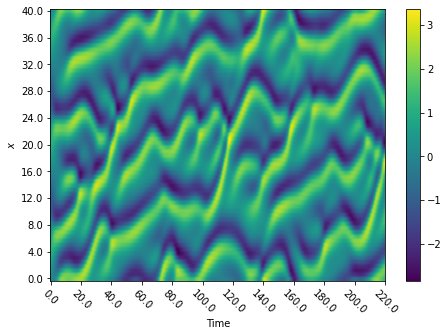

In [12]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [13]:
# making relevant helper arrays to cut off initial transient
num_cases = boundary_idx_arr.shape[0]

initial_t0 = np.array([
    20,
    # 20,
    # 20,
    # 20
])
initial_idx = np.zeros_like(initial_t0)

begin_idx = 0
len_relevant_idx = 0
for i in range(num_cases):
    init_idx = (initial_t0[i] + 0.5*delta_t)//delta_t
    initial_idx[i] = init_idx + begin_idx
    len_relevant_idx += boundary_idx_arr[i] - initial_idx[i]
    begin_idx = boundary_idx_arr[i]

relevant_idx = np.empty(shape=len_relevant_idx, dtype=ITYPE)
start = 0
for i in range(num_cases):
    end = start + (boundary_idx_arr[i] - initial_idx[i])
    relevant_idx[start:end] = np.arange(initial_idx[i], boundary_idx_arr[i])
    start = end

In [14]:
# cutting off initial transient
all_data = all_data[relevant_idx]
# init_idx = 0
# for i in range(num_cases):
#     init_idx += (initial_t0[i] + 0.25*delta_t)//delta_t
#     boundary_idx_arr[i] -= init_idx

prev_boundary_idx = 0
for i in range(num_cases):
    boundary_idx_arr[i] = prev_boundary_idx + (boundary_idx_arr[i] - initial_idx[i])
    prev_boundary_idx = boundary_idx_arr[i]

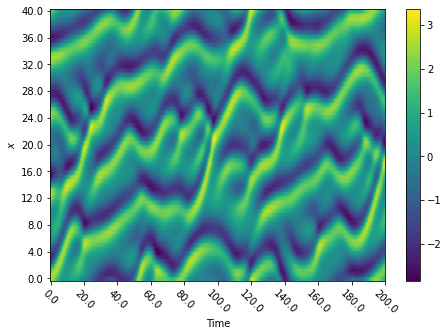

In [51]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [16]:
new_initial_states = np.empty(shape=(num_cases, xgrid.shape[0]))

idx = 0
for i in range(num_cases):
    new_initial_states[i, :] = all_data[idx, :]
    idx = boundary_idx_arr[i]

In [57]:
def compute_lyapunov_spectrum(
        create_data_fn, cdf_kwargs, num_modes, 
        init_state_mat, params_mat, dy_mat,
        zeta=10, delta_completionratio=0.1, num_exp=None):
    '''
    Computing the Lyapunov spectrum
    '''
    starting_time = time.time()

    if len(params_mat.shape) == 1:
        params_mat = params_mat.reshape((1, params_mat.shape[0]))
    if num_exp is None:
        num_exp = num_modes
    elif num_exp > num_modes:
        print('num_exp > num_modes, being set to num_modes.')
        num_exp = num_modes

    T = cdf_kwargs['T']
    t0 = cdf_kwargs['t0']
    delta_t = cdf_kwargs['delta_t']

    N = int(((T-t0) + 0.5*delta_t) // delta_t)

    num_params = params_mat.shape[1]
    num_cases = params_mat.shape[0]

    xi = int((N+1)//zeta)
    print('xi:', xi)
    Rjj_mat = np.ones(shape=(num_cases, xi, num_exp))

    lyap_coeffs = np.empty(shape=(num_cases, num_exp))

    for ii in range(num_cases):
        init_state_unptb = init_state_mat[ii].copy()
        params = params_mat[ii].copy()
        # dY = np.eye(M)*dy
        dY = np.random.rand(num_modes, num_modes) - 0.5
        for j in range(dY.shape[1]):
            dY[:, j] /= np.linalg.norm(dY[:, j])
        dY, _ = linalg.qr(dY)
        dY *= dy_mat[ii]

        # main loop

        # initializing the perturbed states        
        init_state_ptb_mat = np.empty(shape=(num_modes, num_modes))
        for j in range(num_modes):
            init_state_ptb_mat[:, j] = init_state_unptb + dY[:, j]
        
        ptb_state_mat = np.empty(shape=(num_modes, num_modes))

        completion_ratio = delta_completionratio
        t0_star = t0
        unptb_dict = cdf_kwargs.copy()
        unptb_dict['params_mat'] = params
        for i in range(xi):
            # for j in range(zeta):
            T_star = t0_star + zeta*delta_t
            
            # evolving the unperturbed state
            unptb_dict['t0'] = t0_star
            unptb_dict['T'] = T_star
            res_dict_unptb = create_data_fn(init_state=init_state_unptb, **unptb_dict)
            all_data_unptb = res_dict_unptb['all_data']

            # evolving the perturbed states
            ptb_dict_j = unptb_dict.copy()
            for j in range(num_modes):
                init_state_ptb_j = init_state_ptb_mat[:, j].copy()
                res_dict_ptb_j = create_data_fn(init_state=init_state_ptb_j, **ptb_dict_j)
                all_data_ptb_j = res_dict_ptb_j['all_data']
                ptb_state_mat[:, j] = all_data_ptb_j[-1, :]
                dY[:, j] = ptb_state_mat[:, j] - all_data_unptb[-1, :]

            # computing the lyapunov spectrum
            Q_qrdecomp, R_qrdecomp = linalg.qr( dY/dy_mat[ii] )
            for j in range(num_modes):
                fac = 1
                temp = R_qrdecomp[j, j]
                if temp < 0:
                    fac = -1
                if j < num_exp:
                    Rjj_mat[ii, i, j] = fac*temp
                dY[:, j] = dy_mat[ii]*fac*Q_qrdecomp[:, j]

            # updating variables
            t0_star += zeta*delta_t
            init_state_unptb[:] = all_data_unptb[-1, :]
            for j in range(num_modes):
                init_state_ptb_mat[:, j] = init_state_unptb + dY[:, j]

            if i == int(completion_ratio * xi):
                print(
                    'ii: {}, completion_ratio : {}, elapsed_time : {}s'.format(
                        ii,
                        np.round(completion_ratio, 3),
                        np.round(time.time()-starting_time, 3)
                    )
                )
                completion_ratio += delta_completionratio
        
        for j in range(num_exp):
            lyap_coeffs[ii, j] = np.sum(np.log(Rjj_mat[ii, :, j])) / (zeta*xi*delta_t)

    return lyap_coeffs, Rjj_mat

In [58]:
# %pdb
cdf_kwargs = {
    'T':1000,
    't0':t0,
    'delta_t':delta_t,
    'xgrid':xgrid,
    'return_params_arr':return_params_arr,
    'normalize':normalize_flag,
    'alldata_withparams':alldata_withparams_flag,
    'FTYPE':FTYPE,
    'ITYPE':ITYPE
}
create_data_fn = create_KS_data
num_modes = xgrid.shape[0]
init_state_mat = new_initial_states.copy()
dy = 1e-9

dy_mat = np.empty(shape=num_cases)
begin_idx = 0
for i in range(num_cases):
    # dy_mat[i] = dy * np.mean(  np.linalg.norm( all_data[begin_idx:boundary_idx_arr[i]], axis=1 )/xgrid.shape[0]  )
    dy_mat[i] = dy * np.mean( np.linalg.norm( all_data[begin_idx:boundary_idx_arr[i]], axis=0 )/( (boundary_idx_arr[i]-begin_idx)**0.5 ) )
    begin_idx = boundary_idx_arr[i]
    print('dy_mat[{}] :'.format(i), dy_mat[i])
print('')

lpspectrum_mat, _ = compute_lyapunov_spectrum(
    create_data_fn, cdf_kwargs, num_modes, 
    init_state_mat, params_mat, dy_mat,
    zeta=10, delta_completionratio=0.1, num_exp=None)

dy_mat[0] : 1.2941188414627263e-09

xi: 1000
ii: 0, completion_ratio : 0.1, elapsed_time : 28.353s
ii: 0, completion_ratio : 0.2, elapsed_time : 56.555s
ii: 0, completion_ratio : 0.3, elapsed_time : 82.775s
ii: 0, completion_ratio : 0.4, elapsed_time : 108.807s
ii: 0, completion_ratio : 0.5, elapsed_time : 134.938s
ii: 0, completion_ratio : 0.6, elapsed_time : 161.141s
ii: 0, completion_ratio : 0.7, elapsed_time : 187.067s
ii: 0, completion_ratio : 0.8, elapsed_time : 212.867s
ii: 0, completion_ratio : 0.9, elapsed_time : 238.852s
ii: 0, completion_ratio : 1.0, elapsed_time : 264.85s


In [59]:
lpspectrum_mat.sort(axis=1)

In [60]:
lpspectrum_mat[:, -1]

array([0.07702129])

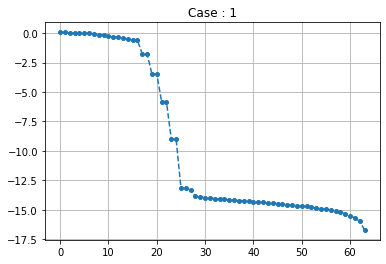

In [61]:
for i in range(num_cases):
    plt.plot(lpspectrum_mat[i, -1::-1], marker='o', linestyle='--', markersize=4)
    plt.grid(True)
    plt.title('Case : {}'.format(i+1))
    plt.show()

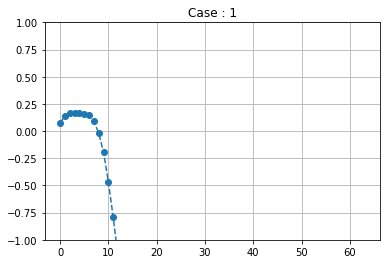

Case 1 : 8


In [62]:
for i in range(num_cases):
    l = lpspectrum_mat[i, -1::-1].copy()
    prev_sum = 0
    for j in range(l.shape[0]):
        prev_sum += l[j]
        l[j] = prev_sum

    plt.plot(l, marker='o', linestyle='--')
    plt.ylim(-1, 1)
    plt.grid(True)
    plt.title('Case : {}'.format(i+1))
    plt.show()

    idx = np.where(np.abs(l) == np.abs(l).min())[0][0]
    print('Case {cn} : {id}'.format(cn=i+1, id=idx))